# notebook mnist

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## MNIST data

In [4]:
x_train,y_train,x_valid,y_valid = get_mnist_data(Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz"))
x_train,x_valid   = normalize_to(x_train,x_valid)

x_train.mean(),x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [5]:
nh,bs              = 50,512
train_ds,valid_ds  = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                        DataLoader(valid_ds,  batch_size=bs*2) )
data               = DataBunch( train_dl, valid_dl, c_in=1, c_out=y_train.max().item()+1 )

In [6]:
mnist_view = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func = F.cross_entropy
sched     = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
#             partial(ParamScheduler, 'lr', sched),             
             partial(BatchTransformXCallback, tfm = mnist_view),
             ProgressCallback]

## mnist without kaiming initialization

In [7]:
cbfs  = cbfs_base.copy() + [LR_Finder]
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2, bn=False) )
learn = Learner( model, data, loss_func, opt=SGD(sched,max_lr=0.5, max_wd=0.01), cb_funcs=cbfs)
%time learn.fit(1)

CPU times: user 9.4 s, sys: 4.74 s, total: 14.1 s
Wall time: 3.91 s


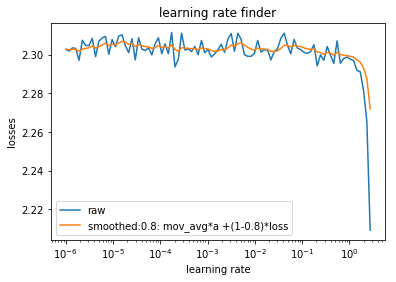

(None, None)

In [8]:
learn.find_subcription_by_cls(LR_Finder).plot_loss(0,5),plt.show()
#learn.find_subcription_by_cls(LR_Finder).plot_lr()

In [9]:
#Training: create model again because current LRFInd does not restore settings in model and opt
cbfs  = cbfs_base.copy()+[Recorder, partial(AvgStatsCallback,[accuracy])]
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2, bn=False) )
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)
%time learn.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.140038,0.261900,1.498738,0.495000,00:04
1,0.648028,0.798240,0.236960,0.927500,00:04
2,0.213531,0.936840,0.169897,0.950000,00:03
3,0.158038,0.952620,0.139167,0.959600,00:03


CPU times: user 38.4 s, sys: 19.2 s, total: 57.7 s
Wall time: 16.9 s


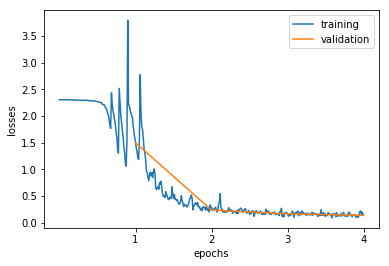

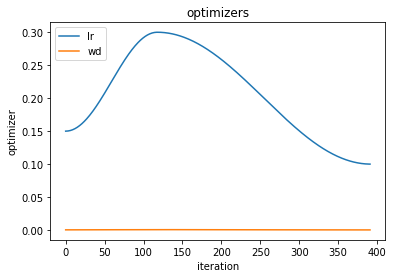

tensor(0.1446)

In [10]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.loss

## mnist with hooks

In [13]:
sched     = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
             partial(BatchTransformXCallback, tfm = mnist_view), ProgressCallback ]

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.299167,0.134160,2.255534,0.241900,00:03
1,1.265456,0.597880,0.412367,0.879500,00:03
2,0.236765,0.930280,0.162514,0.952800,00:03
3,0.138409,0.958220,0.122252,0.963500,00:03


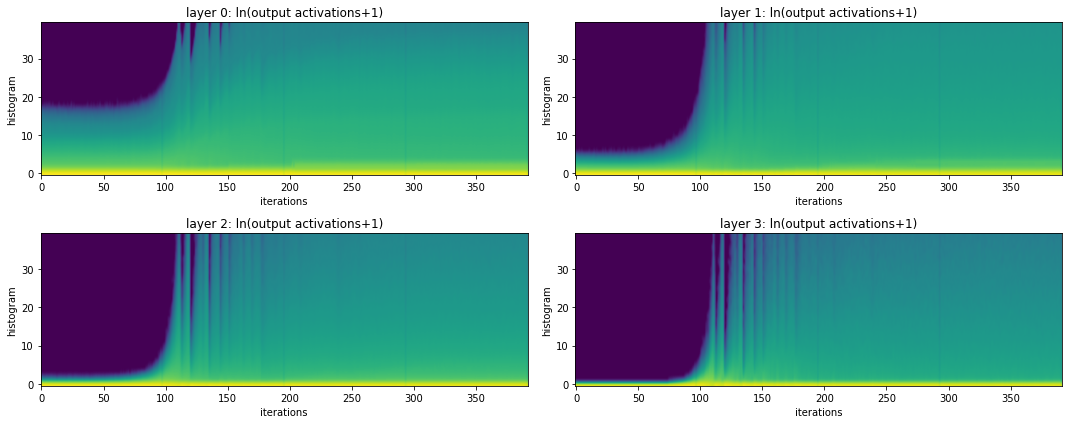

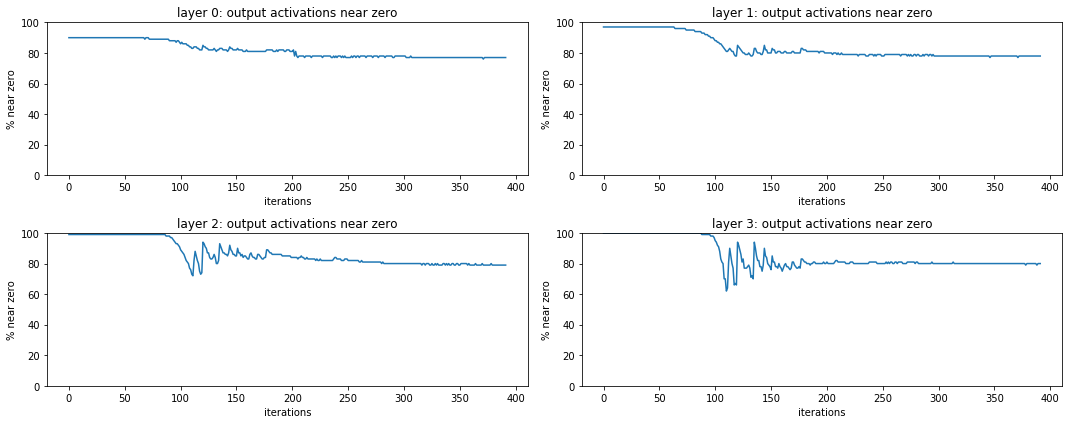

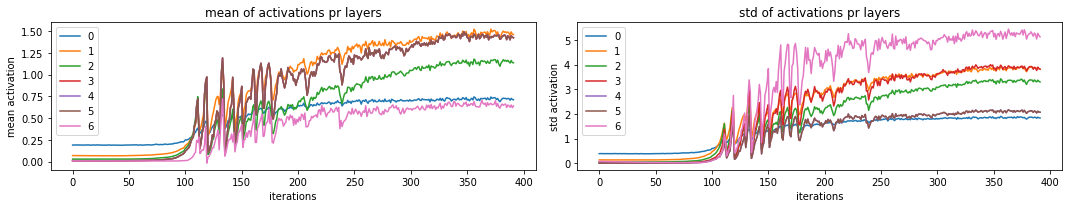

In [14]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2, bn=False) )
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )

## mnist with hooks and kaiming initialization

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.294509,0.595440,0.409148,0.894800,00:04
1,0.281028,0.914120,0.190227,0.944300,00:04
2,0.162724,0.950960,0.133939,0.962100,00:04
3,0.126793,0.961060,0.119531,0.965500,00:04


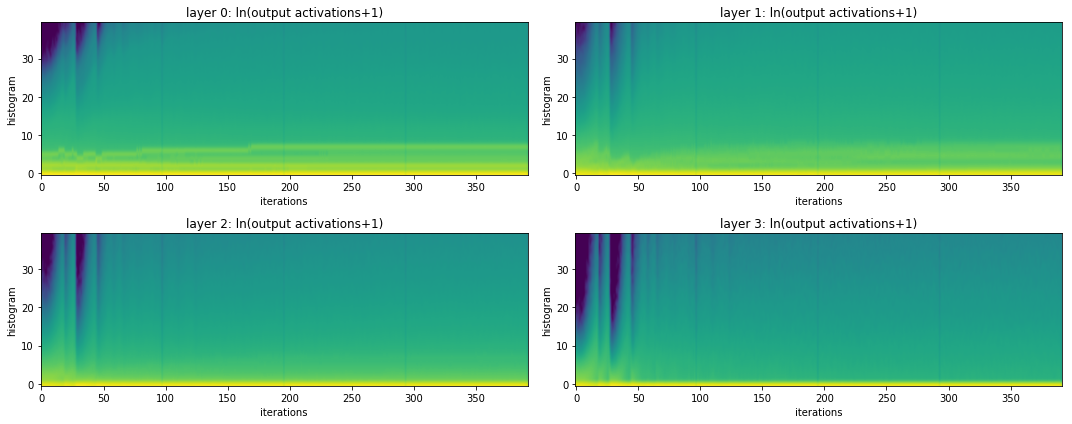

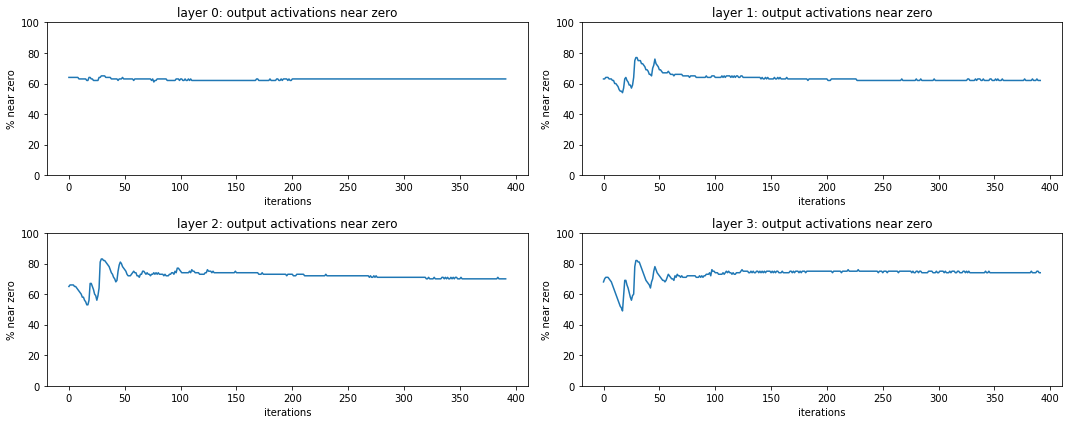

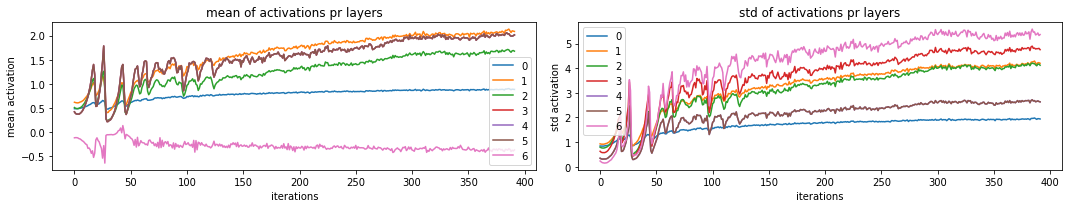

In [21]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2, bn=False) )
init_cnn(model)
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)

with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )

## mnist with hooks + kaiming initialization + batchnorm

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.343576,0.615700,0.411510,0.900800,00:07
1,0.250450,0.935840,0.171005,0.955900,00:07
2,0.141817,0.961660,0.110604,0.971700,00:06
3,0.112257,0.968600,0.097573,0.973500,00:06


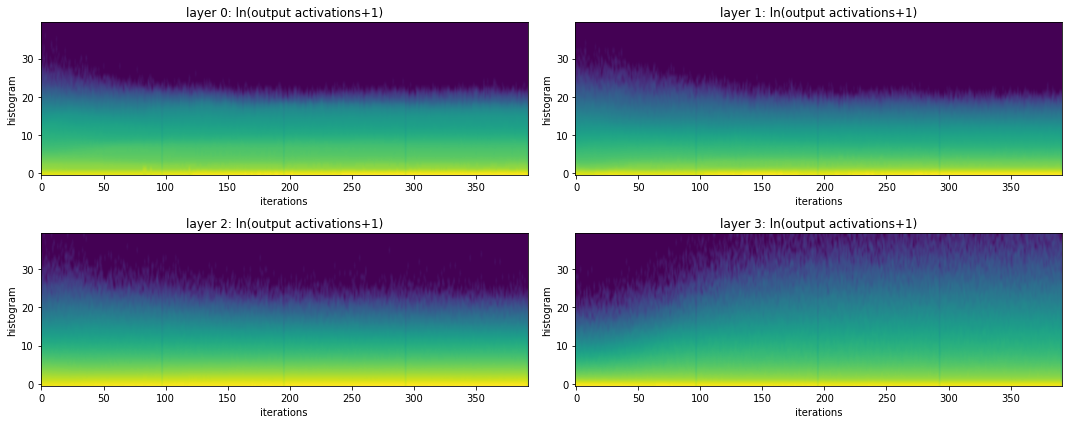

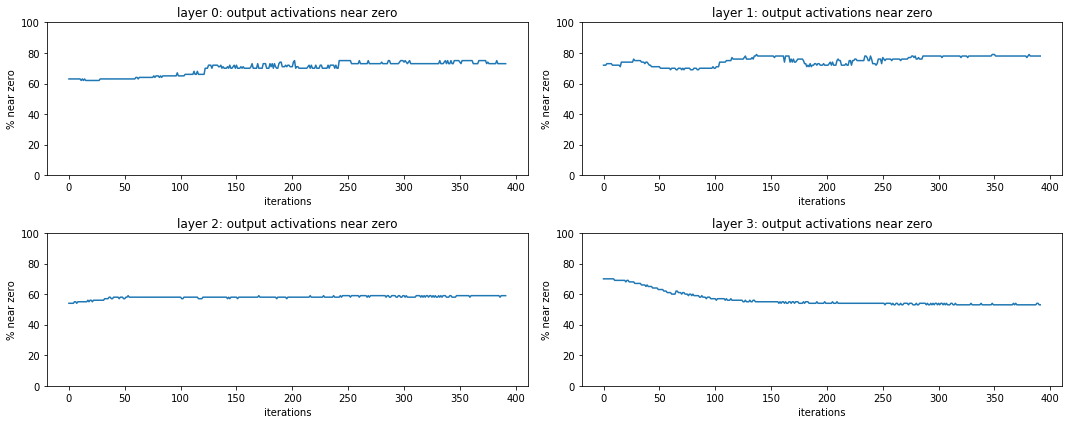

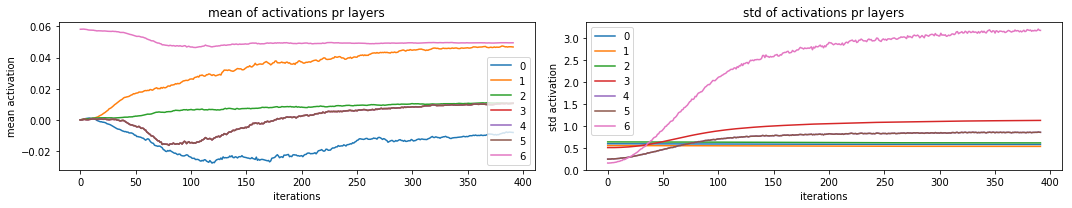

In [22]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2, bn=False) )
init_cnn(model)
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)

with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )